In [1]:
import pandas as pd

df_audio_features = pd.read_csv('/kaggle/input/5ms-upgrade/5MS_audio_features.csv', index_col=0)
df_5MS = pd.read_csv('/kaggle/input/5ms-upgrade/final_5MS.csv', index_col=0)

In [2]:
df_lyrics = df_audio_features.merge(df_5MS, how='right', right_on='id', left_on='id')[['lyrics', 'tag', 'id']]
df_lyrics

,lyrics,tag,id
0,[Produced by Infamous and Drew Correa]\n\n[Int...,rap,2tQM1BUrXp2kqOM6mN11TC
1,[Hook]\nThey wan' do whatever I wan' do\nI got...,rap,04kvMnJ6zo72bSnZDWyE7m
2,"[Intro: The Notorious B.I.G.]\n(""Fuck all you ...",rap,5ByAIlEEnxYdvpnezg7HTX
3,"[Chuck D]\n1, 2, 3, 4, 5, 6, 7, 8, 9\n\n[Intro...",rap,1Z7C8ClE8UEaH70jCCeJH2
4,[Intro: JAY-Z]\nWhat?\nWell fuck you... bitch\...,rap,4LGMSdeKOUoy5Wf75Je0Hl
...,...,...,...
302213,[Instrumental],rb,29EAgZQVXMQwm2O81MffjV
302214,"[Verse 1: Julia Cole, Cooper Alan]\nHate hangi...",country,46XuJOFMgB1biZv3rztHpT
302215,[Instrumental],rb,6yItLFQtv1NVafUWSkmE2S
302216,[Verse 1]\nHalf truth and half you\nDidn't we ...,pop,2bVh1aGyCWxKkZvEn61xZ1


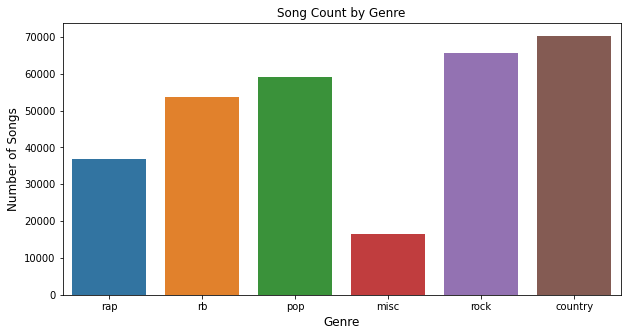

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(x='tag', data=df_lyrics)

plt.title('Song Count by Genre')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

# TO DO: BALANCEAR LA BD

1.     IGUALAR LOS REGISTROS DE CADA CLASE

In [4]:
# grouped_lyrics = df_lyrics.groupby('tag')
# df_balanced = grouped_5MS.apply(lambda x: x.sample(grouped_5MS.size().min())).reset_index(drop=True)

# plt.figure(figsize=(10,5))
# sns.countplot(x='tag', data=df_balanced)

# plt.title('Song Count by Genre')
# plt.ylabel('Number of Songs', fontsize=12)
# plt.xlabel('Genre', fontsize=12)
# plt.show()

# TO DO: PRE-NLP
1. DEFINIR FUNCIONES PARA LIMPIAR LA LYRICS
2. CODEAR LA CLASE

In [5]:
import re
import string
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
translator = str.maketrans("", "", string.punctuation)

def clear_annotations(lyrics):
    return re.sub(r'\[.*\]|\(|\)|\{|\}', '', lyrics)

def remove_punct(lyrics):
    return lyrics.translate(translator)

def remove_stopwords(lyrics):
    filtered_words = [w.lower() for w in lyrics.split() if w.lower() not in stop_words]
    return " ".join(filtered_words)

In [6]:
df_lyrics["lyrics"] = df_lyrics.lyrics.map(clear_annotations).map(remove_punct).map(remove_stopwords)

In [7]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

df_lyrics['tag']= label_encoder.fit_transform(df_lyrics['tag'])

2. CREAR UN DICCIONARIO/CONTADOR CON TODAS LAS LYRICS

In [8]:
from collections import Counter

def counter_word(lyrics_col):
    count = Counter()
    for lyrics in lyrics_col.values:
        for w in lyrics.split(): count[w] += 1
    return count

In [9]:
counter = counter_word(df_lyrics.lyrics)
counter.most_common(5)

[('im', 563534),
 ('like', 448744),
 ('know', 431724),
 ('dont', 396970),
 ('love', 376315)]

In [10]:
num_unique_words = len(counter)

# TO DO: TOKENIZER
1. CODEAR LAS LYRICS
2. AÑADIR PADDING PARA LYRICS DE DISTINTOS TAMAÑOS

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(df_lyrics.lyrics)

In [12]:
words_to_index = tokenizer.word_index

In [13]:
# train_sequences = tokenizer.texts_to_sequences(x_train)
# val_sequences = tokenizer.texts_to_sequences(x_val)
# test_sequences = tokenizer.texts_to_sequences(x_test)

In [14]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# max_length = 200

# train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
# val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
# test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [15]:
import tensorflow as tf
auto = tf.data.AUTOTUNE
batch_size = 128

def make_datasets(lyrics, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((lyrics, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

In [16]:
# train_dataset = make_datasets(train_padded, y_train, is_train=True)
# val_dataset = make_datasets(val_padded, y_val)
# test_dataset = make_datasets(test_padded, y_test)

# TO DO: DIVIDIR LA LA BBDD EN VAL, TEST Y TRAIN
1. SEPARAR TAMBIÉN PARAMETRO DE INTERÉS Y CLASE

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_lyrics.lyrics, df_lyrics.tag, test_size=0.2, random_state=1)

# val_split = 0.1
# val_indices = int(len(x_train) * val_split)
# new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
# x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(x_train)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 241774
Test data samples: 60444


# GloVe
1. LEER EL FICHERO GLOVE

In [18]:
import numpy as np

def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

    return word_to_vec_map
word_to_vec_map = read_glove_vector('/kaggle/input/glove6b/glove.6B.50d.txt')

In [19]:
from keras.layers.embeddings import Embedding

max_length = 200
vocab_len = len(words_to_index)+1
embed_vector_len = word_to_vec_map['moon'].shape[0]
emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=max_length, weights = [emb_matrix], trainable=False)

# TO DO: CNN
1. DEFINIMOS LA ESTRUCTURA DEL MODELO

In [20]:
# from tensorflow import keras
# from tensorflow.keras import layers

# model = keras.models.Sequential()

# # Input / Embdedding
# model.add(layers.Input(shape=(max_length,), dtype='int32'))
# model.add(embedding_layer)

# # CNN
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.Dropout(.6))
# model.add(layers.MaxPooling1D(pool_size=5))

# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.Dropout(.6))
# model.add(layers.MaxPooling1D(pool_size=5))

# model.add(layers.Conv1D(64, 5, activation='relu'))
# model.add(layers.Dropout(.1))
# model.add(layers.MaxPooling1D(pool_size=3))

# model.add(layers.Flatten())

# #NN
# model.add(layers.Dense(32, activation='relu'))

# # Output layer
# model.add(layers.Dense(6, activation="softmax"))

# model.summary()

# TO DO: CROSS VALIDATION PARA PREDECIR TODO EL CONJUNTO DE TRAIN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           24044050  
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          32128     
_________________________________________________________________
dropout (Dropout)            (None, 196, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0

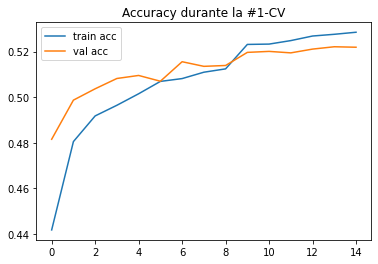

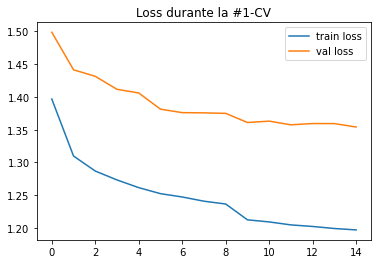

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           24044050  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 128)          32128     
_________________________________________________________________
dropout_3 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 128)           

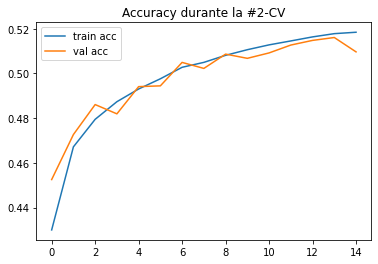

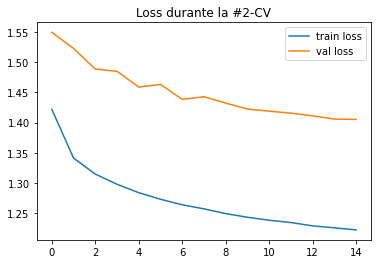

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           24044050  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 196, 128)          32128     
_________________________________________________________________
dropout_6 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 7, 128)           

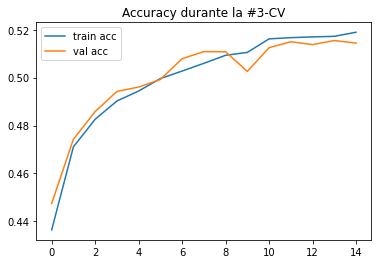

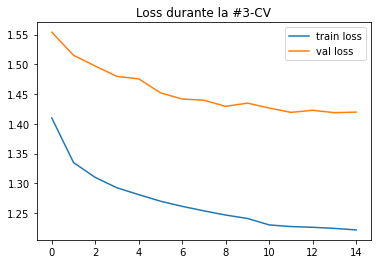


Métricas en entrenamiento:


,precision,recall,f1-score,support
0,0.593413,0.734106,0.656304,56105.000000
1,0.828120,0.179518,0.295072,13124.000000
2,0.292384,0.270167,0.280837,47219.000000
3,0.653735,0.677163,0.665243,29439.000000
4,0.545134,0.451196,0.493736,43152.000000
5,0.494445,0.559571,0.524996,52735.000000
accuracy,0.517897,0.517897,0.517897,0.517897
macro avg,0.567872,0.478620,0.486031,241774.000000
weighted avg,0.524503,0.517897,0.506799,241774.000000


In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from tensorflow import keras
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding


cv = KFold(n_splits=3, random_state=42, shuffle=True)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

pred_probs_train = np.zeros((len(y_train), len(np.unique(y_train))))
best_score = 0
best_model_path = None
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.2,
                                                 patience=2,
                                                 min_lr=0.000001)

for i, (train_index, test_index) in enumerate(cv.split(x_train, y_train)):
    
    checkpoint_filepath = f"/kaggle/working/tmp/checkpoint_{i+1}"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                          monitor="val_accuracy",
                                                          save_best_only=True,
                                                          save_weights_only=False)
    
    x_train_cv, x_test_cv = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # creacion de bases de datos
    train_dataset = make_datasets(
        pad_sequences(
            tokenizer.texts_to_sequences(x_train_cv),
            maxlen=max_length, padding="post",
            truncating="post"),
        y_train_cv, is_train=True)
    
    val_padded = pad_sequences(
            tokenizer.texts_to_sequences(x_test_cv),
            maxlen=max_length, padding="post",
            truncating="post")
    val_dataset = make_datasets(val_padded, y_test_cv)
    
    # construccion del modelo
    model = keras.models.Sequential()
    model.add(layers.Input(shape=(max_length,), dtype='int32'))
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.Dropout(.6))
    model.add(layers.MaxPooling1D(pool_size=5))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.Dropout(.6))
    model.add(layers.MaxPooling1D(pool_size=5))
    model.add(layers.Conv1D(64, 5, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.MaxPooling1D(pool_size=3))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(6, activation="softmax"))

    model.summary()
    
    # entrenamiento del modelo
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[checkpoint_callback, reduce_lr])
    
    plt.title(f'Accuracy durante la #{i+1}-CV')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()
    
    plt.title(f'Loss durante la #{i+1}-CV')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    
    # predicciones sobre el conjunto test de la cv
    model.load_weights(checkpoint_filepath)
    pred_probs_train[test_index] = model.predict(val_padded)
    score = accuracy_score(y_test_cv, np.argmax(pred_probs_train[test_index], axis=1))
    
    if score > best_score:
        best_score = score
        best_model_path = checkpoint_filepath
        

y_train_pred = np.argmax(pred_probs_train, axis=1)
report = classification_report(y_train, y_train_pred, output_dict=True)

print('\nMétricas en entrenamiento:')
pd.DataFrame(report).T 

# TO DO: TESTEAR LA PRECISIÓN
0. 'country' 
1. 'misc' 
2. 'pop'
3. 'rap'
4. 'rb'
5. 'rock'

In [22]:
model.load_weights(best_model_path)

test_padded = pad_sequences(
            tokenizer.texts_to_sequences(x_test),
            maxlen=max_length, padding="post",
            truncating="post")

pred_probs_test = model.predict(test_padded)
y_test_pred = np.argmax(pred_probs_test, axis=1)
report = classification_report(y_test, y_test_pred, output_dict=True)

print('\nMétricas en test:')
pd.DataFrame(report).T


Métricas en test:


,precision,recall,f1-score,support
0,0.589996,0.754209,0.662072,14138.000000
1,0.867318,0.182970,0.302190,3394.000000
2,0.301660,0.210668,0.248083,11905.000000
3,0.676201,0.664024,0.670057,7441.000000
4,0.537287,0.481954,0.508118,10584.000000
5,0.474486,0.604529,0.531671,12982.000000
accuracy,0.524155,0.524155,0.524155,0.524155
macro avg,0.574491,0.483059,0.487032,60444.000000
weighted avg,0.525351,0.524155,0.506343,60444.000000


# TO DO: GUARDAR LAS PRED_PROBAS DE TRAIN

In [23]:
df_pred_probs_train = pd.DataFrame(pred_probs_train, columns = ['prob_0','prob_1','prob_2','prob_3','prob_4','prob_5'])
y_train.reset_index(drop=True, inplace=True)

df_train = pd.merge(df_pred_probs_train, y_train, right_index=True, left_index=True)
df_train.to_csv('/kaggle/working/predicts_vs_real_TRAIN.csv')

# TO DO: DEVOLVER PROBABILIDADES PREDICHAS Y CLASE REAL EN TEST

In [24]:
df_pred_probs_test = pd.DataFrame(pred_probs_test, columns = ['prob_0','prob_1','prob_2','prob_3','prob_4','prob_5'])
y_test.reset_index(drop=True, inplace=True)

df_test = pd.merge(df_pred_probs_test, y_test, right_index=True, left_index=True)
df_test.to_csv('/kaggle/working/predicts_vs_real_TEST.csv')